# Assignment 4 : "RNN/CNN and keyphrase extraction "
Due: Monday 2pm, Feburary 15, 2021, via Moodle

### Submission guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will find many provided codes in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do *not* hand in a separate file for it.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle.

## Task 1: Spam Detection (3 + 3 + 2 + 4 + 1) = 13 Points

In this task we tackle the task of Spam Detection (Text Classification) using RNNs and CNNs. To start download the `spam.csv` file from Moodle. 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, Conv1D,Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
tf.random.set_seed(12)

In [11]:
df = pd.read_csv('./data/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Sub Task 1: Pre-processsing 

There are some unnecessary columns in the data `Unnamed:2 to 4`. Remove those and rename the remaining columns to `labels` and `text`. 

In [12]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True) ### your code ###
df.rename(columns={"v1": "labels", "v2": "text"}, inplace=True)
df.head()

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Notice that the labels are string values. We need to convert them to integers of `0` and `1` for Tensorflow to understand. Create a new column called `binary_labels` and save the binary values in there. Then split the dataset into train and test set using `sklearn`, where the test data is 20 precent of the entire set. Then use 20 percent of the training set for your validation set. Convert them into a `tensorflow.Dataset` for training and test, shuffle the `dataset_train` and set the batch_size of both dataset to `16`. You can change the batch size to a smaller value if your device does not support it. Set the random_state for both to `12`. 

In [13]:
df['binary_labels'] = (df['labels']=="spam").astype(int) ### your code ###
X = df['text']
Y = df['binary_labels'] ### your code ###
# split up the data
X_train, X_test, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=12) ### your code ###
X_train, X_val, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=12) ### your code ###

In [45]:
dataset_train = (
    tf.data.Dataset.from_tensor_slices((tf.cast(X_train, tf.string), tf.cast(Ytrain, tf.int32)))) ### your code ###
dataset_train = dataset_train.shuffle(10000).batch(16, drop_remainder=True) ### shuffle, set batch to 16 ###

dataset_val = (
    tf.data.Dataset.from_tensor_slices((tf.cast(X_val, tf.string), tf.cast(Yval, tf.int32))))  ### your code ###
dataset_val = dataset_val.batch(16, drop_remainder=True) ### set batch to 16 ###

dataset_test = (
    tf.data.Dataset.from_tensor_slices((tf.cast(X_test, tf.string), tf.cast(Ytest, tf.int32)))) ### your code ###
dataset_test = dataset_test.batch(16, drop_remainder=True) ### set batch to 16 ###

for feat, targ in dataset_train.take(1):
    print ('Features: {}, Target: {}'.format(feat, targ))
    print ('Features: {}'.format(feat[0]))

Features: [b'Lol enjoy role playing much?' b'So when do you wanna gym?'
 b'Wanna do some art?! :D' b"Yay can't wait to party together!"
 b'I know complain num only..bettr directly go to bsnl offc nd apply for it..'
 b'Near kalainar tv office.thenampet'
 b'Yes I know the cheesy songs from frosty the snowman :)'
 b'Velly good, yes please!'
 b'Sorry about earlier. Putting out fires.Are you around to talk after 9? Or do you actually have a life, lol!'
 b'\\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEAD 2 DA WRLD. BEEN SLEEPING ON DA SOFA ALL DAY'
 b'Spoons it is then okay?' b'Howz that persons story'
 b"MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOULDN'T BE A PROBLEM."
 b'Wait 2 min..stand at bus stop' b'Is ur paper today in e morn or aft?'
 b'Mum not going robinson already.'], Target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Features: b'Lol enjoy role playing much?'


Set the vocabulary size to `10000` and use the `TextVectorization` class to preprocess the textual data and turn it into integer vectors. Set the lenght of the output sequence to `128`. Any sequence with more tokens will be truncated and shorter sequences will be padded to fit the size. 

In [15]:
encoder = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=128)
dataset_train_features = dataset_train.map(lambda features, label: features)
encoder.adapt(dataset_train_features)
### your code ###

In [16]:
# run this cell to make sure your output makes sense 
vocab = np.array(encoder.get_vocabulary())
print("Encoded",encoder(feat).numpy()[0]) # this should output the encoded vector with integer values to the size of 128 
print("Original: ", feat.numpy()[0]) # the orginal text should be retrieved 
print("After vectorization: ", " ".join(vocab[encoder(feat).numpy()[0]])) #text with preprocessing (lowercase and normalization)

Encoded [220  40  79 134   3  32 928   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Original:  b'\xc3\x8c\xc3\x8f no home work to do meh... '
After vectorization:  ÌÏ no home work to do meh                                                                                                                         


## Sub Task 2: Create the LSTM Model and Train

In this sub task you will use a RNN with LSTM cells for text classification. We use the Keras functional API for our model building. Below you will see the summary output of our model. Use this as a basis to model your own network with the same layers: 
```
Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_88 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_9 (TextVe (None, 128)               0         
_________________________________________________________________
embedding_73 (Embedding)     (None, 128, 64)           640064    
_________________________________________________________________
lstm_41 (LSTM)               (None, 128, 32)           12416     
_________________________________________________________________
global_max_pooling1d_39 (Glo (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 33        
=================================================================
Total params: 652,513
Trainable params: 652,513
Non-trainable params: 0
```
Train the model for 6 epochs with the `fit` function, using the validation set for intermediate testing. Use the Adam optimizer with default parameters and binary cross entropy loss. Also keep track of the accuracy during training so we can plot it later. You can specify the metric you would like to track, when compiling your model. The value of the loss and the callback function for accuracy will be saved in the `history` of the returned object for `fit` function. 

In [17]:
# Create the model
embedding_dim = 64
hidden_dim = 32
vocab_length = len(vocab)

x_in = Input(shape=(1,), dtype="string")
x = encoder(x_in)### pre-processing ### 
x = Embedding(input_dim=vocab_length, output_dim=embedding_dim, embeddings_initializer='uniform')(x) ### embedding ###
x = LSTM(units=32, return_sequences=True)(x) ### lstm - keep in mind the output shape is (None, 128, 32) meaning that ALL the hidden states are returned and not just the final one ###
x = GlobalMaxPooling1D()(x) ### max pool over everything ### 
x_out = Dense(1, activation='sigmoid')(x)

lstm_model = tf.keras.models.Model(inputs=x_in, outputs=x_out,name="lstm_model") ### build model ### 
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 64)           536704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 32)           12416     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 549,153
Trainable params: 549,153
Non-trainable params: 0
__________________________________________________

In [18]:
# Compile and fit
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']) ### your code ### 
print('Training model...')
history_lstm = lstm_model.fit(dataset_train, epochs=6, validation_data=dataset_val) ### your code ### 

Training model...
Epoch 1/6
279/279 [==============================] - 12s 38ms/step - loss: 0.3826 - accuracy: 0.8880 - val_loss: 0.1074 - val_accuracy: 0.9749
Epoch 2/6
279/279 [==============================] - 9s 33ms/step - loss: 0.0535 - accuracy: 0.9900 - val_loss: 0.0928 - val_accuracy: 0.9767
Epoch 3/6
279/279 [==============================] - 10s 35ms/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 0.1050 - val_accuracy: 0.9767
Epoch 4/6
279/279 [==============================] - 10s 35ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.1267 - val_accuracy: 0.9722
Epoch 5/6
279/279 [==============================] - 10s 36ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.1315 - val_accuracy: 0.9749
Epoch 6/6
279/279 [==============================] - 10s 36ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.1340 - val_accuracy: 0.9740


In [19]:
# Plot loss per iteration 
# => see next cell
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric]) 
### your code ### 

(0.0, 0.2651993041159585)

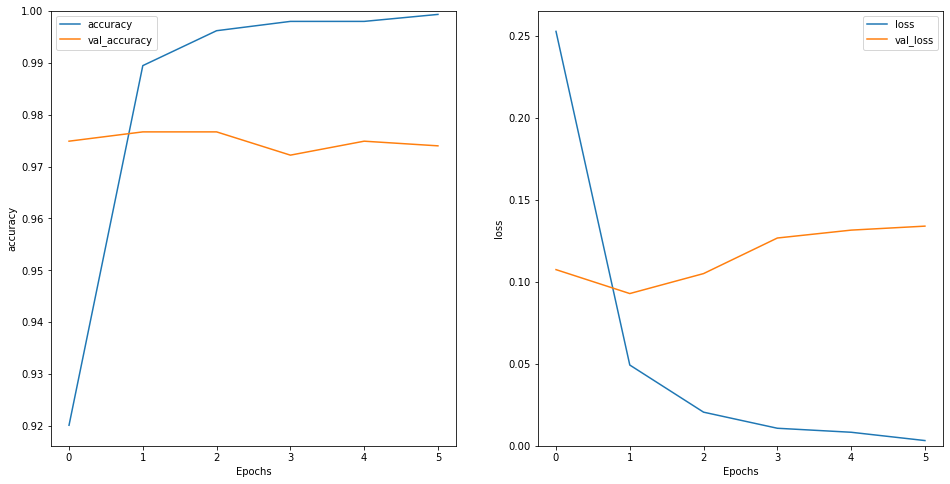

In [20]:
# Plot accuracy per iteration
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history_lstm, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history_lstm, 'loss')
plt.ylim(0,None)
### your code ### 

## Sub Task 3: Create the CNN Model and Train

We want to use the same data but this time with a CNN architecture to classify the spam emails. Once again, use this model summary to create a similiar network: 
```
Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_89 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_9 (TextVe (None, 128)               0         
_________________________________________________________________
embedding_74 (Embedding)     (None, 128, 64)           640064    
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 126, 32)           6176      
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 42, 32)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 40, 64)            6208      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 13, 64)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 13, 1)             65        
=================================================================
Total params: 652,513
Trainable params: 652,513
Non-trainable params: 0
```
Train the model for 6 epochs using the validation set for intermediate testing. Use the Adam optimizer with default parameters and binary cross entropy loss, keep track of the accuracy during training so we can plot it later. Note that the CNN trains much quicker than the LSTM network since it can be parallelized easier on a GPU. 

In [21]:
# Create the model
embedding_dim = 64

x_in = Input(shape=(1,), dtype="string")
x = encoder(x_in) ### pre-processing ### 
x = Embedding(input_dim=vocab_length, output_dim=embedding_dim, embeddings_initializer='uniform')(x) ### embedding ### 
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x) ### first conv, activation='relu', filter_size= can you guess? ### 
x = MaxPooling1D(pool_size=3)(x) ### first maxpool, filter_size= can you guess?   ### 
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x) ### second conv, activation='relu', filter_size= can you guess?  ### 
x = MaxPooling1D(pool_size=3)(x) ### second maxpool, filter_size= can you guess?   ### 
x_out = Dense(1, activation='sigmoid')(x)

cnn_model = tf.keras.models.Model(inputs=x_in, outputs=x_out,name="cnn_model")### build model ### 
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 128)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 64)           536704    
_________________________________________________________________
conv1d (Conv1D)              (None, 126, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 42, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0 

In [22]:
# Compile and fit
cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']) ### your code ### 
print('Training model...')
history_cnn = cnn_model.fit(dataset_train, epochs=6, validation_data=dataset_val)  ### your code ### 

Training model...
Epoch 1/6
279/279 [==============================] - 3s 8ms/step - loss: 0.4351 - accuracy: 0.8685 - val_loss: 0.3395 - val_accuracy: 0.8879
Epoch 2/6
279/279 [==============================] - 2s 9ms/step - loss: 0.3259 - accuracy: 0.8941 - val_loss: 0.3370 - val_accuracy: 0.8893
Epoch 3/6
279/279 [==============================] - 2s 9ms/step - loss: 0.3232 - accuracy: 0.8943 - val_loss: 0.3400 - val_accuracy: 0.8900
Epoch 4/6
279/279 [==============================] - 2s 8ms/step - loss: 0.3083 - accuracy: 0.9010 - val_loss: 0.3413 - val_accuracy: 0.8902
Epoch 5/6
279/279 [==============================] - 2s 8ms/step - loss: 0.3090 - accuracy: 0.9003 - val_loss: 0.3422 - val_accuracy: 0.8896
Epoch 6/6
279/279 [==============================] - 2s 9ms/step - loss: 0.3177 - accuracy: 0.8954 - val_loss: 0.3454 - val_accuracy: 0.8893


In [23]:
# Plot loss per iteration 
# => see next cell
### your code ### 

(0.0, 0.3826774016022682)

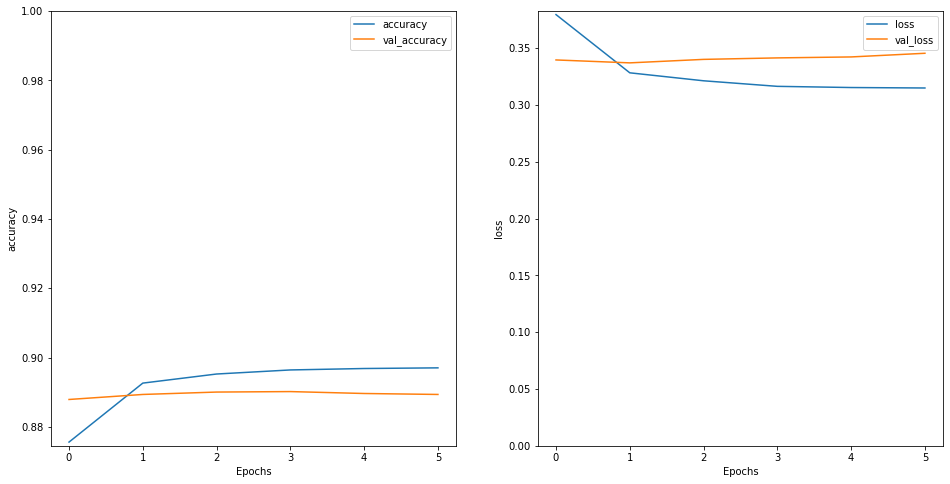

In [24]:
# Plot accuracy per iteration
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history_cnn, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history_cnn, 'loss')
plt.ylim(0,None)
### your code ### 

## Sub Task 4: Mix and Match

Let's use the power of the functional API to stack our two models together. Our final model takes as input two parallel branches and combine them to get a final output. One input passage will go through our LSTM network and the other through our CNN network. Keep in mind that you need to remove the last sigmoid layer of the both models for it to work properly. The output of two models are concatenated and passed through two additional `Dense` layers. Here is the model summary of the model you need to replicate: 

```
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_85 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_86 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_9 (TextVecto (None, 128)          0           input_85[0][0]                   
                                                                 input_86[0][0]                   
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 128, 20)      200020      text_vectorization_9[51][0]      
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 126, 32)      1952        embedding_71[0][0]               
__________________________________________________________________________________________________
max_pooling1d_65 (MaxPooling1D) (None, 42, 32)       0           conv1d_70[0][0]                  
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 128, 20)      200020      text_vectorization_9[50][0]      
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 40, 64)       6208        max_pooling1d_65[0][0]           
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 128, 15)      2160        embedding_70[0][0]               
__________________________________________________________________________________________________
max_pooling1d_66 (MaxPooling1D) (None, 13, 64)       0           conv1d_71[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_37 (Global (None, 15)           0           lstm_39[0][0]                    
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 832)          0           max_pooling1d_66[0][0]           
__________________________________________________________________________________________________
tf.concat_10 (TFOpLambda)       (None, 847)          0           global_max_pooling1d_37[0][0]    
                                                                 flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 128)          108544      tf.concat_10[0][0]               
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 1)            129         dense_46[0][0]                   
==================================================================================================
Total params: 519,033
Trainable params: 519,033
Non-trainable params: 0
_____________________________
```
Train the model for 4 epochs using the validation set for intermediate testing. Use the Adam optimizer with default parameters and binary cross entropy loss, keep track of the accuracy during training so we can plot it later. Note that the input should be a list containing your training features (twice), the same applies for the validation set and later the test set. This is due to the fact that your model has two input branches, however, since the output branch is still one, no changes are needed for the loss function or target values.


In [116]:
# define two sets of inputs
inputA = Input(shape=(1,), dtype="string", name="inputA")
inputB = Input(shape=(1,), dtype="string", name="inputB")

# the first branch operates on the first input
x = encoder(inputA) ### pre-processing ### 
x = Embedding(input_dim=vocab_length, output_dim=embedding_dim, embeddings_initializer='uniform')(x) ### Embedding ### 
x = LSTM(units=32, return_sequences=True)(x) ### lstm_model ###
x = GlobalMaxPooling1D()(x) ### lstm_model ###
x = Model(inputs=inputA, outputs=x)


# the second branch operates on the second input
y = encoder(inputB) ### pre processing ### 
y = Embedding(input_dim=vocab_length, output_dim=embedding_dim, embeddings_initializer='uniform')(y) ### Embedding ### 
y = Conv1D(filters=32, kernel_size=3, activation='relu')(y) ### cnn_model ###
y = MaxPooling1D(pool_size=3)(y) ### cnn_model ###
y = Conv1D(filters=64, kernel_size=3, activation='relu')(y)### cnn_model ###
y = MaxPooling1D(pool_size=3)(y) ### cnn_model ###
y = Flatten()(y) ### we need to flatten the data to remove the additional dimension here
y = Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = tf.concat([x.output,y.output], axis=1) ### your code ### 

# combined outputs
z = Dense(1, activation="sigmoid")(combined) ### your code ### 
z = Dense(1, activation="sigmoid")(z)

# our model will accept the inputs of the two branches and then output a single value
mix_model = Model(inputs=[x.input, y.input], outputs=z)
mix_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputA (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputB (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 128)          0           inputA[0][0]                     
                                                                 inputB[0][0]                     
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 128, 64)      536704      text_vectorization_1[9][0]

In [135]:
# Compile and fit
mix_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])### your code ### 
print('Training model...')
train_features_twice = {"inputA": X_train, "inputB": X_train}
val_features_twice = {"inputA": X_val, "inputB": X_val}

history_mix = mix_model.fit(x=train_features_twice,
                            y=Ytrain, epochs=4, validation_data=(val_features_twice,Yval))

Training model...
Epoch 1/4
140/140 [==============================] - 8s 44ms/step - loss: 0.1747 - accuracy: 0.8690 - val_loss: 0.2021 - val_accuracy: 0.8655
Epoch 2/4
140/140 [==============================] - 6s 41ms/step - loss: 0.1612 - accuracy: 0.8734 - val_loss: 0.1954 - val_accuracy: 0.8655
Epoch 3/4
140/140 [==============================] - 6s 42ms/step - loss: 0.1637 - accuracy: 0.8623 - val_loss: 0.1888 - val_accuracy: 0.8655
Epoch 4/4
140/140 [==============================] - 7s 49ms/step - loss: 0.1510 - accuracy: 0.8671 - val_loss: 0.1828 - val_accuracy: 0.8655


In [ ]:
# Plot loss per iteration 
# => see next cell
### your code ### 

(0.0, 0.20467118695378303)

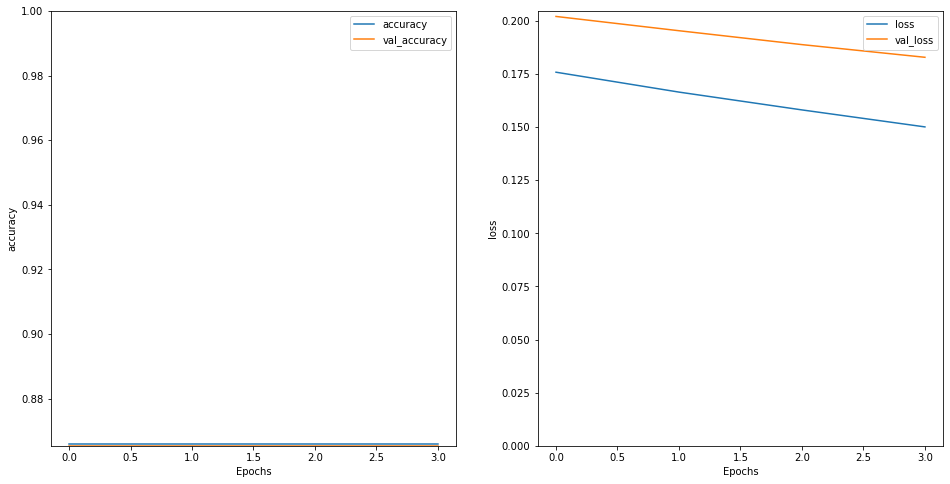

In [136]:
# Plot accuracy per iteration
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history_mix, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history_mix, 'loss')
plt.ylim(0,None)
### your code ### 

## Sub Task 5: Comparision 

Use the `evaluate` function to compare the performance of the three models on the test set. Which one works better? 

In [138]:
def get_evaluation(model, dataset):
    test_loss, test_acc = model.evaluate(dataset)
    return test_loss, test_acc

print("Test score lstm (accuracy): {}".format(get_evaluation(lstm_model, dataset_test)[1])) ### your code ### )
print("Test score cnn (accuracy): {}".format(get_evaluation(cnn_model, dataset_test)[1])) ### your code ### )
dataset_test_twice = {"inputA": X_test, "inputB": X_test}
print("Test score mix (accuracy): {}".format(mix_model.evaluate(x=dataset_test_twice, y=Ytest)[1]))

print("=> The lstm model works best")

69/69 [==============================] - 1s 7ms/step - loss: 0.1352 - accuracy: 0.9737
Test score lstm (accuracy): 0.9737318754196167
69/69 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8896
Test score cnn (accuracy): 0.8896321654319763
35/35 [==============================] - 0s 10ms/step - loss: 0.1828 - accuracy: 0.8655
Test score mix (accuracy): 0.865470826625824
=> The lstm model works best


## Task 2: Theoretical Questions (1+1+1+1+1+1+1+1) = 8 Points  

### Sub Task 1: 

While training an RNN at the *t*-th time-step, what probability is the RNN computing? ($w_t$ is the word at time $t$). 

### Sub Task 2: 

Consider the following two scenarios for the language model:  
(i) During training,  
(ii) After training, while using the language model to sample.  
**For both cases answer the following:** How is the next word chosen? What value is passed on to the next time step? 

### Sub Task 3: 

While training your RNN, you realise that your weights and activations have taken the value of `NaN` (not a number), what can be the cause of this? Name one method to avoid this problem.  (short answer) 

### Sub Task 4: 

You have a pet dragon, whose mood is heavily dependent on the weather on the current and past few days. You have collected data of the weather for the past 365 days as $w_1,...,w_{365}$, where $w_1$ is the first day of your recording, and $w_{365}$ the most recent day. You also recorded the mood of your dragon as $y_1,...,y_{365}$ corresponding to the individual days. To avoid any "dragon accidents", you want to predict her mood for the next days. Would you use a unidirectional or bidirectional RNN? Justify your answer. 

### Sub Task 5: 

You have an input of shape `(84x3)` and you convolve (1D) it with `16` filters of size `7`, using a stride of `2` and no padding. What is the output dimension?  
What if you had an image of shape `(84x84x3)` (last dimension is the RGB channel) and you convolve it with `32` filters of shape `(7x7)`, using a stride of `2` and no padding. What is the shape of the output volume?

The question is independent of the batch size, imagine a single example. 

## Sub Task 6: 

What is the effect of pooling layers in terms of the derivative for backpropagation? 

### Sub Task 7: 

You have an input volume of shape `(32x32x64)` and you apply *max pooling* with stride `4` and a filter size of `2`. What is the size of the output volume? The question is independent of the batch size, imagine a single example. 

## Sub Task 8



You trained a classifier using a convolutional neural network that stacked 4 convolutional layers to differentiate images of animals. There are 100 different classes of animals the network classifies. Now you want to find a hidden unit that strongly indicates that the image is a dragon, i.e., a hidden unit that is strongly activated when shown an image of a dragon. In which of the four layers are you most likely to find such a unit?

## Task 3: Unsupervised Keyphrase Extraction (4+3+2) = 9 Points

In this task, we will implement a simple unsupervised keyphrase extraction module utilizing a simple grammatical ruling system, which we apply to a Sherlock Holmes novel. To generate TF-IDF-weighted phrases, we will be using the entire collection from Sir Arthur Donan Coyle to calculate document frequencies.

### Sub Task 1: Extract Keyphrase Candidates
We will generate a set of suitable candidate phrases by using spaCy's rule-based `Matcher` class.
The pattern should satisfy the following rules for a valid candidate:

1. An optional adjective, noun, proper noun
2. An optional adjective, noun, proper noun, or adposition
3. A mandatory noun or proper noun.

This will match phrases of an length of 1-3 tokens, which is a suitable rule of thumb to start with.

In [ ]:
import spacy
from spacy.matcher import Matcher

In [ ]:
nlp = spacy.load( # load the spaCy model "en", and disable named entity recognition #
matcher = # Instantiate a Matcher object with the vocabulary of the "en" module #

pattern = ### your code ###
matcher.add( # Append your pattern to the matcher class #

In [ ]:
# Run to verify correctness of your rule-based matcher. Should return "11" if correctly implemented.
doc = nlp("This is a simple test. It should return 'simple', and 'test'. Maybe we can also see if it can recognize the art of war. Would it recognize integer linear programming, too?")
matches = matcher(doc)
print(len(matches))

Once you have matched the correct number of keyphrase candidates on the above example, apply your rule-based matcher to an actual data sample. We are going to use the Sherlock Holmes novel "Hounds of Baskervilles". You can find the raw text file at the following URL:

https://sherlock-holm.es/stories/plain-text/houn.txt

Download the text from this URL and apply your spacy model and matcher on it.  
**Hint:** Make sure you properly decode your input, since some libraries return binary strings.

In [ ]:
def load_txt_from_url(url="https://sherlock-holm.es/stories/plain-text/houn.txt"):
  ### your code here ###
  return text

text = load_txt_from_url()

doc = ### your code here ###
matches = ### your code here ###

We will now investigate which phrase candidates are the most frequently appearing in this novel, simply based on the phrase frequency. Therefore, convert your abstract match objects into actual strings, lowercase them, and return the 10 most frequently occurring phrase candidates and their respective frequencies.

In [ ]:
### your code ###

#### Briefly summarize the quality of your top 10 candidates:

YOUR ANSWER

### Sub Task 2: Generating Document Frequency Values

To compare the previously generated terms with a more refined model, we are going to extract document frequencies from the collection of all Sherlock Holmes works. Since the books are relatively long documents, we are instead going to split based on a simple heuristic in the input document, which should allow a decent approximation by taking into account individual chapters of each novel.

Start by loading the Sherlock Holmes canon from https://sherlock-holm.es/stories/plain-text/cnus.txt

Afterwards, split the full document into individual chapters. For this, use three consecutive line breaks `\n\n\n` as a splitting condition to approximate the chapters.

In [ ]:
### your code ###

After splitting, you should have 353 individual "documents" to work with. Now, create a dictionary containing each phrase encountered in the larger corpus, and its associated document frequency. 

**Hint:** Since the processing of 353 documents might take a while, you can incorporate tools such as `tqdm.tqdm` to visualize progress on the task.

In [ ]:
def return_occurring_phrases(doc_text):
  # should return the candidate phrases which occur in a single "document"

# iterate over all generated documents

# Afterwards, count the number of individual documents a phrase occurred in.

In [ ]:
# Print the 10 most frequent phrases according to the df-counts, to verify your result.

### Sub Task 3: Generating Weighted Keyphrases

We can now incorporate the extracted keyphrases to calculate tf_idf scores, and return a hopefully improved version of our keyphrases for the original novel.
Iterate over all phrases occurring in the novel, and weigh them according to the definition of TF-IDF. Use the smoothed definition of idf:

$ idf(t, D) = \log \frac{N}{|\{d \in D : t \in d\}| + 1} + 1 $

In [ ]:
def tf_idf
  return ### your code ###

### calculate the weights for each candidate phrase from the "Hounds of Baskervilles" ###

Now print the top 10 candidate phrases by TF-IDF weight, and compare the results to your previous output. Can you give reasons as to why some of the phrases might be occurring?

In [ ]:
### your code ###

COMPARE YOUR RESULTS

Give two examples of how you could further improve the list of keyphrase values.


YOUR ANSWER

